In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to yeast interactome (various kinds of genetic and physical interactions, with particular emphasis on protein-protein interactions).

In [1]:
%matplotlib inline

# utilities
import gc
import time
import os

import itertools
import collections

# data analysis tools
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
import tqdm
import qgrid

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp

os.chdir("/home/vvi/Science/eQTL_analysis/")

# visualization tools
import matplotlib.pyplot as plt

from lib import networks
from lib import qtls
from lib import ontologies

gc.enable()

%autosave 15

Autosaving every 15 seconds


## Datasets used

Take a look at readme.md in /data folder for data description. (currently unavailable)

In [2]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants
full_genotypes_df = pd.read_table("./data/genotypes/processed_genotypes.csv")

''' Where possible, gene names were converted from systematic to standard notation '''
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/averaged_expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/processed_genotypes.csv")
eQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/averaged_expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/processed_genotypes.csv")
pQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)

# pandas DataFrame —> numpy matrix = 2x speedup
pQTLs_expression_mx = \
    pQTLs_expression_df.as_matrix(
        columns=pQTLs_expression_df.columns[1:]
    )
pQTLs_genotypes_mx = \
    pQTLs_genotypes_df.as_matrix(
        columns=pQTLs_genotypes_df.columns[1:]
    )

# QTLs estimated with MatrixEQTL package for R
eQTLs_df = pd.read_table("./data/eQTLs/results.csv")
# eQTLs_df = eQTLs_df[eQTLs_df["q.value"] <= 0.05]
pQTLs_df = pd.read_table("./data/pQTLs/results.csv")
# pQTLs_df = pQTLs_df[pQTLs_df["q.value"] <= 0.05]

# Physical and genetic interactions taken from TheBioGrid project
full_interactome_df = pd.read_table("./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association",
    "colocalization",   
    "direct interaction",
    "physical association"
]
interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

# Genetic nomenclature and mappings between different naming conventions (official lookup table)
gene_nomenclature_df = pd.read_table("./data/nomenclature/yeast_gene_nomenclature_mapping.csv")
gene_nomenclature_df.drop_duplicates("Systematic name", inplace=True)

std_to_sys = dict(zip(
    gene_nomenclature_df["Standard name"].values, 
    gene_nomenclature_df["Systematic name"].values
))
sys_to_std = {v: k for k, v in std_to_sys.items()}

# Functional modules found in PPI graph 
# according to the data published at http://thecellmap.org/costanzo2016/
functional_modules_df = pd.read_table("./data/interactions/bioprocess_annotations_costanzo2016.csv")
functional_module_names = [s.replace('/', '|') for s in np.unique(functional_modules_df["Function"].values)]

## Introduction and problem formulation

The plot below compares the distributions of eQTLs (blue) and pQTLs (yellow) in the yeast genome. Many hotspots are common, but effect sizes differ.  
**TODO:** Обозначить отрезки хромосом на оси геномных координат.

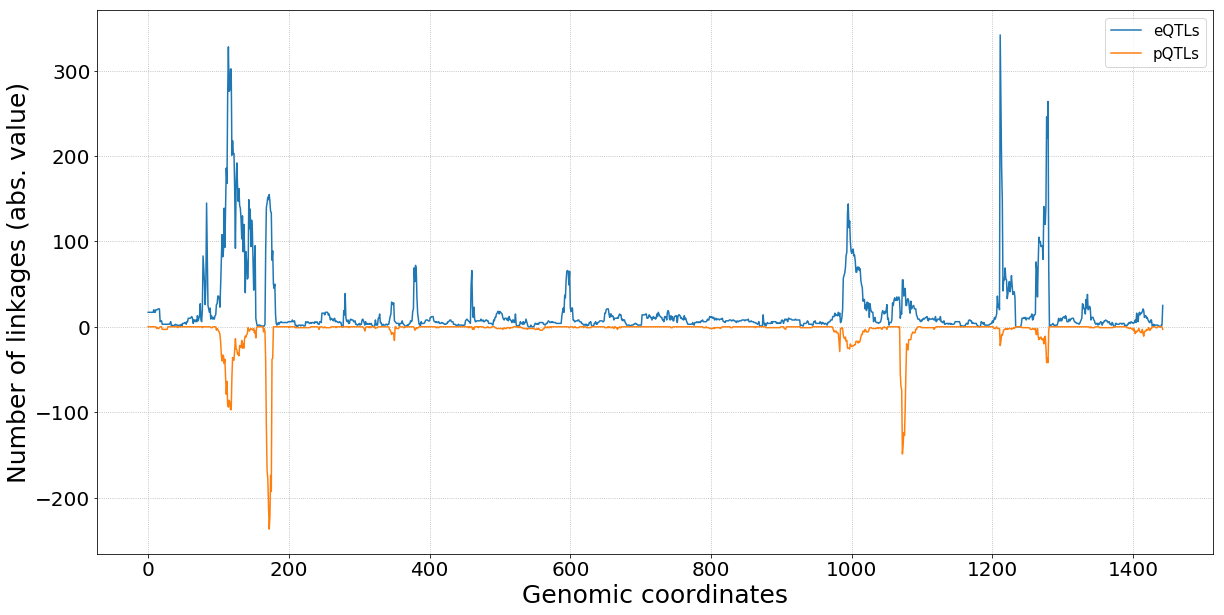

In [3]:
eQTL_y = np.array(qtls.map_linkages_to_genome_location(eQTLs_df, full_genotypes_df)[1])
pQTL_y = np.array(qtls.map_linkages_to_genome_location(pQTLs_df, full_genotypes_df)[1])

plt.figure(figsize=(20, 10))
plt.plot(eQTL_y, label="eQTLs")
plt.plot(-pQTL_y, label="pQTLs")
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.grid(linestyle="dotted")
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png", dpi=300)


Both eQTLs and pQTLs were computed from expression data using [MatrixEQTL](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3348564/) — a tool for R programming language.  
The same results very also previously obtained using naive approach: just take all (marker, gene) pairs, divide expression into groups by inhertied polymorphism, calculate the p-value using MWU test and do FDR-correctness with [q-value](https://github.com/StoreyLab/qvalue) package.  
Results can be viewed separately on graphs below.

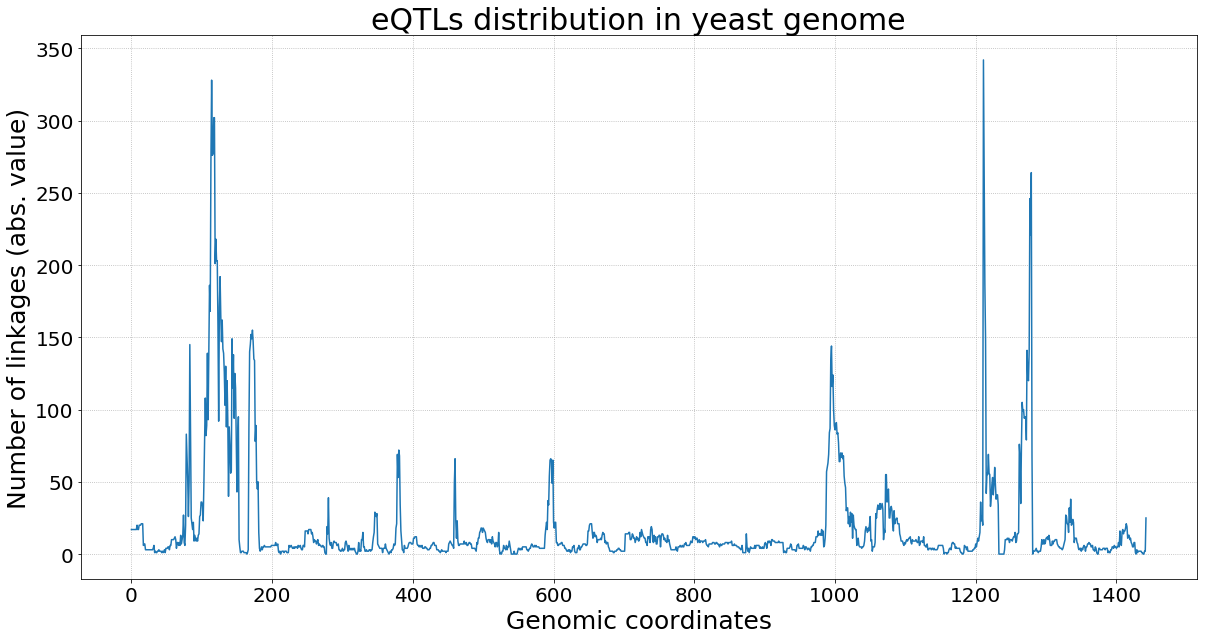

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.title("eQTLs distribution in yeast genome", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linestyle="dotted")
plt.show()
plt.close()

%reset_selective eQTL_y

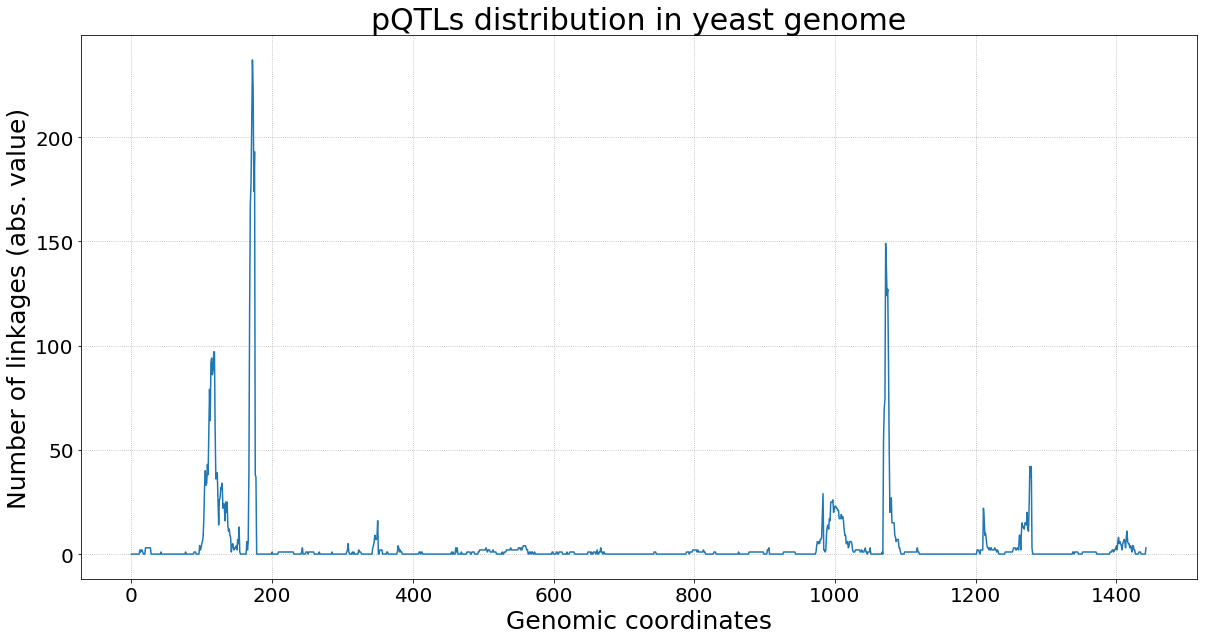

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(pQTL_y)
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.title("pQTLs distribution in yeast genome", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linestyle="dotted")
plt.show()
plt.close()

%reset_selective pQTL_y

It seems rational to suppose that transcription and translation levels must be controlled by similar genetic mechanisms.  
Unfortunately, at the first sight there is no evidence to support that intuition: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes. This is illustrated by the histogram below.

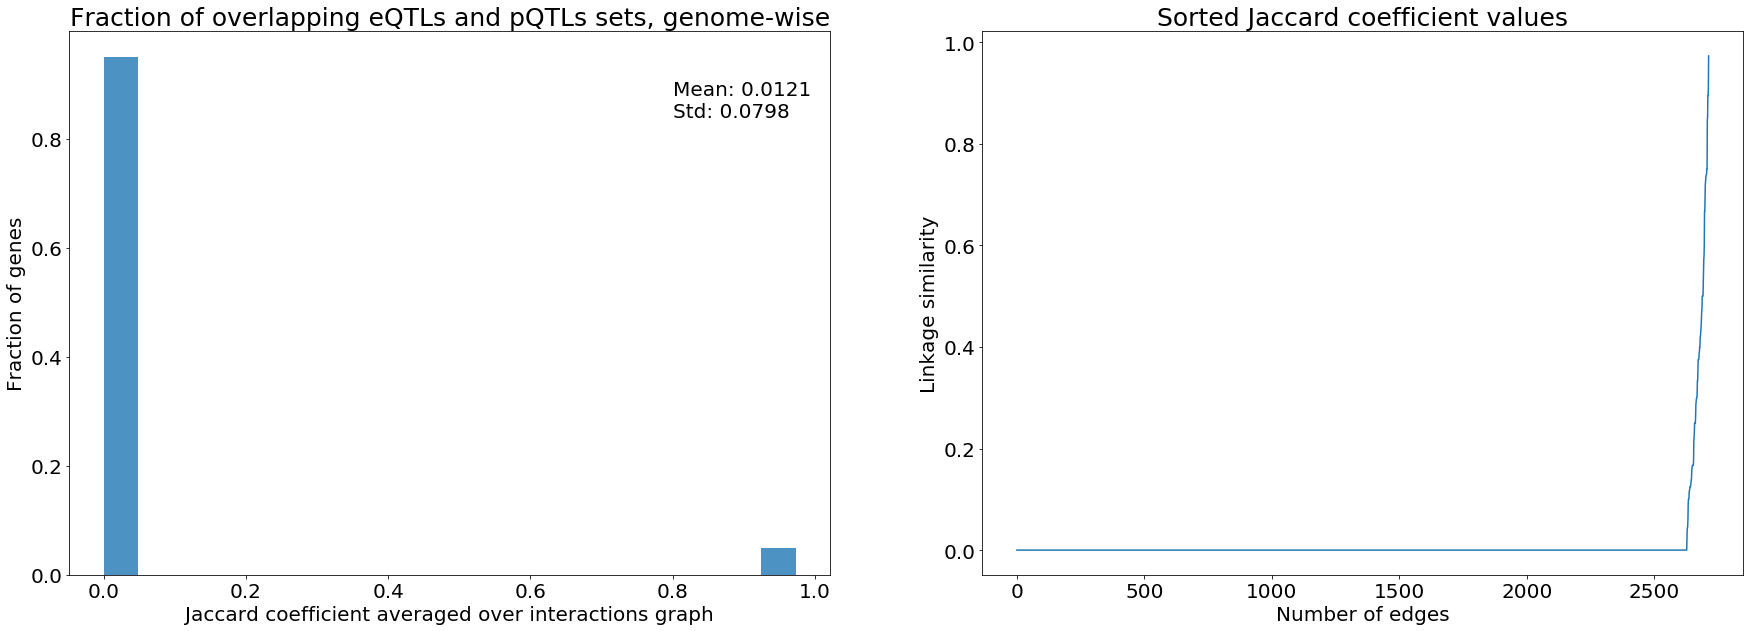

In [18]:
genes_with_linkages_of_both_types = np.unique(np.append(eQTLs_df["gene"].values, pQTLs_df["gene"].values))
linkage_overlap_data = []
for gene_name in genes_with_linkages_of_both_types:
    linked_eQTLs = set(eQTLs_df[eQTLs_df["gene"] == gene_name]["SNP"].values)
    linked_pQTLs = set(pQTLs_df[pQTLs_df["gene"] == gene_name]["SNP"].values)
    linkage_overlap_data.append(qtls.jaccard(linked_eQTLs, linked_pQTLs))
linkage_overlap_data = np.array(linkage_overlap_data)

fig = plt.figure(figsize=(30, 10))
hist_ax = fig.add_subplot(1, 2, 1)

hist, bin_edges = np.histogram(linkage_overlap_data, bins=20, density=True)
weights = np.ones_like(hist)/float(len(hist))
hist_ax.hist(hist * np.diff(bin_edges), bin_edges, weights=weights, alpha=0.8);
hist_ax.tick_params(axis='x', labelsize=20)
hist_ax.tick_params(axis='y', labelsize=20)
hist_ax.set_xlabel("Jaccard coefficient averaged over interactions graph", fontsize=20)
hist_ax.set_ylabel("Fraction of genes", fontsize=20)
hist_ax.text(
    0.8, 0.8, 
    "Mean: {0:.4f}\nStd: {1:.4f}\n".format(
        linkage_overlap_data.mean(), linkage_overlap_data.std()
    ), 
    fontsize=20
)
hist_ax.set_title("Fraction of overlapping eQTLs and pQTLs sets, genome-wise", fontsize=25);

sdata_ax = fig.add_subplot(1, 2, 2)
sdata_ax.plot(sorted(linkage_overlap_data))
sdata_ax.set_xlabel("Number of edges", fontsize=20)
sdata_ax.set_ylabel("Linkage similarity", fontsize=20)
sdata_ax.tick_params(axis='x', labelsize=20)
sdata_ax.tick_params(axis='y', labelsize=20)
sdata_ax.set_title("Sorted Jaccard coefficient values", fontsize=25)

plt.savefig("img/linkages/eQTLs_pQTLs_linkage_overlap.png", dpi=300)

%reset_selective genes_with_linkages_of_both_types|linkage_overlap_data|fig|hist|bin_edges|weights|hist_ax|sdata_ax
gc.collect();


Hypothesis arises: maybe not single genes, but functional modules tend to share linkages.  
The goal of this work is to test that hypothesis using yeast interactome data.

## Interacting genes tend to share linkage: bird's eye view.

First, it can be shown that interacting genes tend to share linkages.  
To establish that the following procedure was used:   
- Generate 1000 FDR-cutoffs in range 1e-8...1e-2
- For each threshold:
	- Select subset of significant QTLs according to given threshold
	- Divide interactions into categories and extract corresponding subgraphs
	- Perform subgraph clusterization and calculate mean Jaccard coefficient between eQTL- and pQTL-linkage sets for each cluster. Average of those is taken to be mean linkage similarity measure. No sophisticated clustering is used at the moment: each edge forms its own cluster. Nevertheless, this proves to be sufficient to show statistically significant dependence.
	- In order to ensure that observed linkage similarity is not an artefact of interactions graph structure and not its biological meaning, those graphs are randomized preserving degree sequence and analyzed in the same manner. These experiments provide strong evidence for hypothesis being tested: mean linkage similarity becomes significantly smaller. 


In [5]:
def extract_interactions(interactions_df):
    '''
    Helper function to retrieve the edges of the graph of interactions     
    '''
    return interactions_df[["Interactor A", "Interactor B"]].values

interaction_graphs_dict = {}
for category_name in interaction_categories:
    interacting_genes_df = interactome_df[interactome_df.index == category_name]
    interaction_graphs_dict[category_name] = networks.graph_from_edges(
        extract_interactions(interacting_genes_df),
    )
    
interaction_graphs_dict.update(dict(zip(["all", "genetic", "physical"],
    itertools.starmap(networks.graph_from_edges, 
        [(extract_interactions(interactome_df), False, False),
         (extract_interactions(genetic_interactions_df), False, False), 
         (extract_interactions(physical_interactions_df), False, False)]
    )))
)

In [ ]:
Q_RANGE = np.logspace(-8, -2, 100)

for qtl_type, qtl_df in [("eQTLs", eQTLs_df), ("pQTLs", pQTLs_df)]:
    for interaction_type, interaction_graph in interaction_graphs_dict.items():
        interaction_graph_analyzer = qtls.LinkageSharingAnalyzer(
            qtl_type=qtl_type,
            qtl_df=qtl_df,
            module_name=interaction_type,
            module_graph=interaction_graph,
            q_value_thresholds=Q_RANGE
        )
        interaction_graph_analyzer.analyze_robustness_of_linkage_sharing(
            title=qtl_type + " linkage similarity for " 
                  + (interaction_type if interaction_type not in ["genetic", "physical"] 
                                      else interaction_type + " interactions"),
            destination_folder="./img/linkage_sharing/thebiogrid/"
        )

%reset_selective Q_RANGE

## Predicting pQTLs from eQTLs using PPI networks

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), it will serve as an additional evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results).  

The main idea is not to test all (marker, gene) pairs but to filter for trusted only. In order to get rid of the pairs that will not link (or at least to dump more false than real linkages), the following approach is proposed: 
1. For each gene with measured protein abundance select its eQTL linkages as candidates into pQTLs. 
2. Extend eQTL linkages with those of the interacting genes. 

FDR decreases for the same q-value threshold, which results in more trustworthy observations.

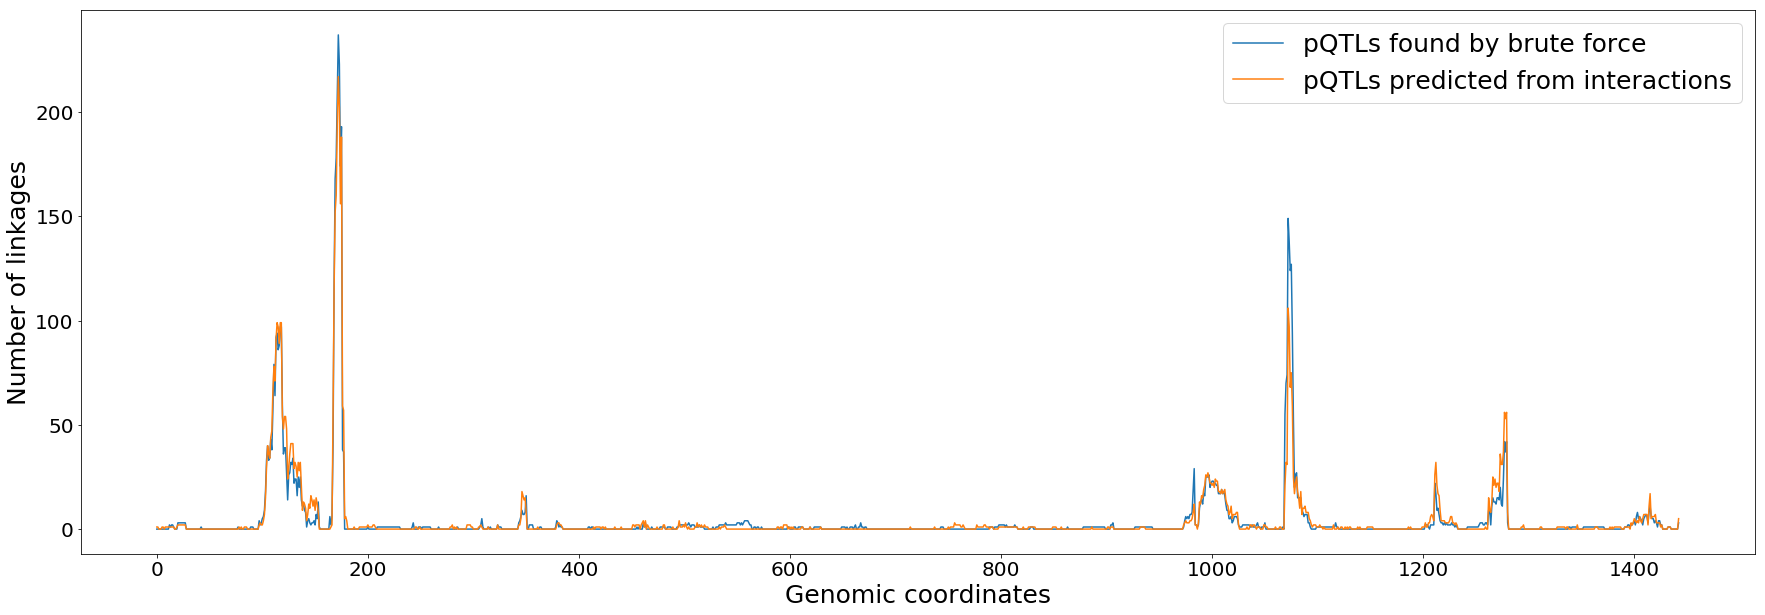

In [7]:
pqtl_finder = qtls.PqtlPredictor(
    eQTLs_df, pQTLs_df,
    eQTLs_expression_df, eQTLs_genotypes_df,
    pQTLs_expression_df, pQTLs_genotypes_df,
    full_genotypes_df,
    "full interactome",
    networks.graph_from_edges(extract_interactions(interactome_df))
)

results = pqtl_finder.predict()

%reset_selective pqtl_finder

Here is some statistics computed from some subgraphs of the interactome. 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Full interactome**:
- Common linkages: 3688, 59.85069782538137%
- Old linkages, total: 6162
- New linkages, total: 6219
- New linkages found: 2531

It becomes evident, that a significant fraction of estimated pQTLs can be reproduced using this approach.  
**Nevertheless, many questions arise**:
- Which fraction of trans-pQTLs is reproduced? (and is this approach capable of detecting those)
- Are all the hotspots reproduced? If some are not, why then? It is worth mentioning, that some of those were given cryptic names which are nowhere to be found. 
- How robust the results are? So far results are not compared with those computed from simulated, perturbed graphs. 

## Interacting genes tend to share linkages: analysis of coarse-grained functional modules

The problem is, interaction types given in the BioGrid database are too general from the biological viewpoint.  
It's worth investigating in more detail, which biological processes demonstrate statistically significant link between regulation mechanisms of different expression types.  
In order to do so, curated functional modules taken from the ["Global Genetic Interaction Dataset"](http://thecellmap.org/costanzo2016) (University of Toronto) are tested, among those:
- Cell polarity & morphogenesis
- Cytokinesis
- DNA replication & repair
- Glycosylation, protein folding|targeting, cell wall biosynthesis
- MVB sorting and pH depending signaling
- Metabolism
- Mitosis & chromosome segregation
- Nuclear-cytoplasmic transport
- Peroxisome
- Protein degradation|turnover
- Respiration, oxidative phosphorylation, mitochondrial targeting
- Ribosome biogenesis
- Transcription & chromatin organization
- Vesicle traffic
- mRNA & tRNA processing
- rDNA & ncDNA processing
- tRNA wobble modification

**All images from this section can be found in /img/functional_module_graphs/ and /img/linkage_sharing/thecellmap directories.**

In [13]:
functional_modules_dict = {}
for module_name in functional_module_names:
    functional_modules_dict[module_name] = functional_modules_df[
        functional_modules_df["Function"].str.contains(module_name)
    ]["Interactor (std)"].values

First of all, let's take a look at subgraphs which represent those modules.  
**TODO:** Find out how to make beuatiful networks plots. Igraph's defaults are messy.

In [ ]:
def extract_module_subgraphs(functional_modules_dict, interactome_graph, simplify=False):
    module_graphs_dict = {}
    for mname in functional_modules_dict.keys():
        mgraph = interactome_graph.subgraph(
            set(functional_modules_dict[mname])
            & set(interactome_graph.vs["name"])
        )
        if simplify:
            mgraph = mgraph.simplify()
            mgraph.vs.select(_degree=0).delete()
        ig.plot(
            mgraph, 
            layout=mgraph.layout_kamada_kawai(),
            target="./img/functional_module_graphs/" 
                   + ("simplified/" if simplify else "raw/") 
                   + mname + ".png",
            vertex_label=mgraph.vs["name"]
        );
        module_graphs_dict[mname] = mgraph
    return module_graphs_dict

pd.DataFrame(
    [(mname, mgraph.vcount(), mgraph.ecount()) for mname, mgraph in 
     extract_module_subgraphs(functional_modules_dict, interaction_graphs_dict["all"]).items()], 
    columns=["Module name", "Num. vertices", "Num. edges"]
)

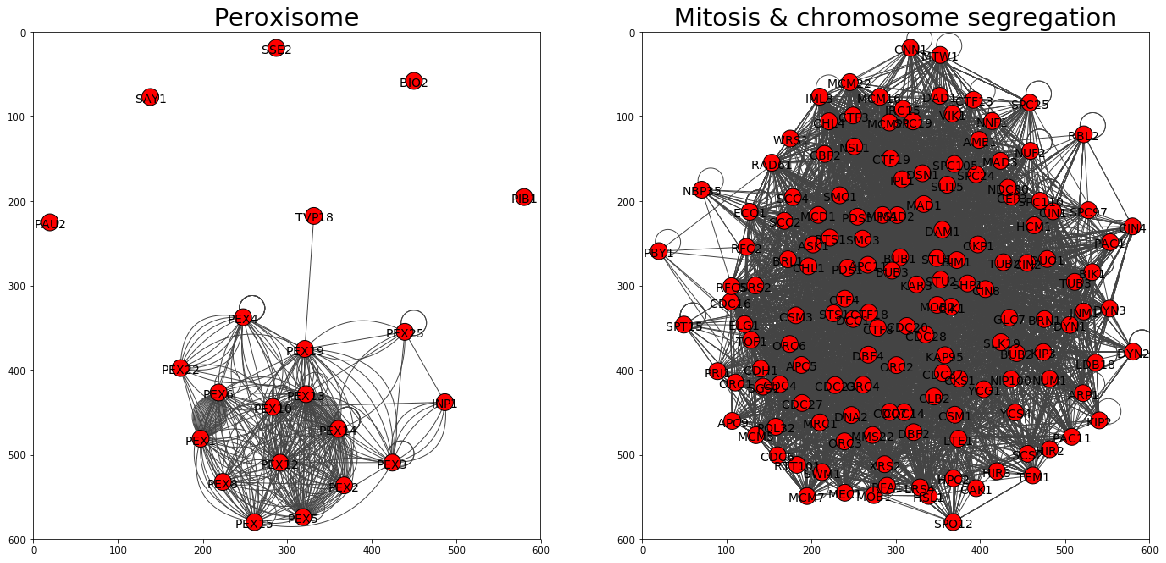

In [25]:
f, axarr = plt.subplots(1, 2, figsize=(20,20))
axarr[0].imshow(plt.imread("./img/functional_module_graphs/raw/Peroxisome.png"))
axarr[0].set_title("Peroxisome", fontsize=25)
axarr[1].imshow(plt.imread("./img/functional_module_graphs/raw/Mitosis & chromosome segregation.png"))
axarr[1].set_title("Mitosis & chromosome segregation", fontsize=25)
plt.show()


It's clear from the data above, that most of the modules are tiny (65 vertices on average) compared to whole interactome which comprises of **6611 vertices** and **681490 edges**.  
There even are clusters on 4, 11 and 14 vertices. The owerwhelming amount of multiedges and loops is also worth mentioning.  
Removing those drastically reduces the modules' sizes, as is shown below.

In [26]:
pd.DataFrame(
    [(mname, mgraph.vcount(), mgraph.ecount()) for mname, mgraph in 
     extract_module_subgraphs(
         functional_modules_dict, 
         interaction_graphs_dict["all"], 
         simplify=True).items()
     ], 
    columns=["Module name", "Num. vertices", "Num. edges"]
)

,Module name,Num. vertices,Num. edges
0,Metabolism,11,29
1,Protein degradation|turnover,44,551
2,Ribosome biogenesis,67,170
3,Nuclear-cytoplasmic transport,35,431
4,tRNA wobble modification,14,64
5,rDNA & ncDNA processing,76,982
6,DNA replication & repair,75,1228
7,Transcription & chromatin organization,85,1917
8,Mitosis & chromosome segregation,149,4198
9,Cytokinesis,4,6


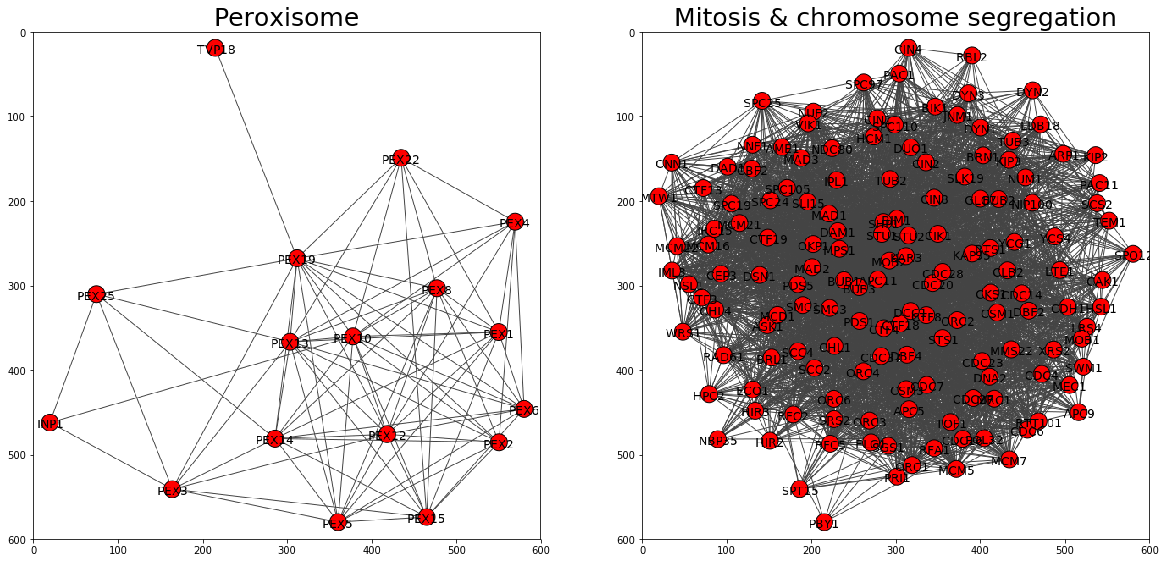

In [27]:
f, axarr = plt.subplots(1, 2, figsize=(20,20))
axarr[0].imshow(plt.imread("./img/functional_module_graphs/simplified/Peroxisome.png"))
axarr[0].set_title("Peroxisome", fontsize=25)
axarr[1].imshow(plt.imread("./img/functional_module_graphs/simplified/Mitosis & chromosome segregation.png"))
axarr[1].set_title("Mitosis & chromosome segregation", fontsize=25)
plt.show()

%reset_selective .*module_graphs_dict

In [ ]:
%%capture --no-stderr

Q_RANGE = np.logspace(-8, -2, 100)

for interaction_type in ["all", "genetic", "physical"]:
    interactome_graph = interaction_graphs_dict[interaction_type]
    for qtl_type, qtl_df in [("eQTLs", eQTLs_df), ("pQTLs", pQTLs_df)]:
        for module_name in functional_modules_dict.keys():
            module_graph = interactome_graph.subgraph(
                set(functional_modules_dict[module_name])
                & set(interactome_graph.vs["name"])
            ).simplify()
            module_graph.vs.select(_degree=0).delete()
            if module_graph.vcount() <= 2:
                print("{} — no data!".format(module_name))
                continue
            
            module_graph_analyzer = qtls.LinkageSharingAnalyzer(
                qtl_type=qtl_type,
                qtl_df=qtl_df,
                module_name=module_name,
                module_graph=module_graph,
                q_value_thresholds=Q_RANGE
            )
    
            module_graph_analyzer.analyze_robustness_of_linkage_sharing(
                title=qtl_type + " linkage similarity for " + module_name + " functional module",
                destination_folder="./img/linkage_sharing/thecellmap/" + interaction_type + "_interactions/"
            )
            
gc.collect()
%reset_selective interactome_graph

Unfortunately, the results obtained this way are more controversial.  
For the data computed from **the whole interactome graph** there are few clusters with average linkage similarity curve lying strictly above than those of the simulated graphs.  
Among those are:  
- Mitosis & chromosome segregation (strong positive effect for eQTLs and slight negative one for pQTLs)
- Glycosylation, protein folding/targeting, cell wall biosynthesis (pQTLs only)
- Repsiration, oxidative phosphorylation, mitochondrial targeting (strong effect for eQTLs, a lot of noise in case of pQTLs)
- Transcription and chromatin organization (eQTLs only)
- rDNA & ncDNA processing (pQTLs only)  

These are, respectively, the 1st, 2nd, 3rd, 4th and 5th clusters when sorted by number of vertices in descending order.  
**If only physical or genetic interactions are taken into consideration, results are slightly different but they all agree.**  
Readers can check that themselves by looking at the visualizations in /img/linkage_sharing/thecellmap/ directory.


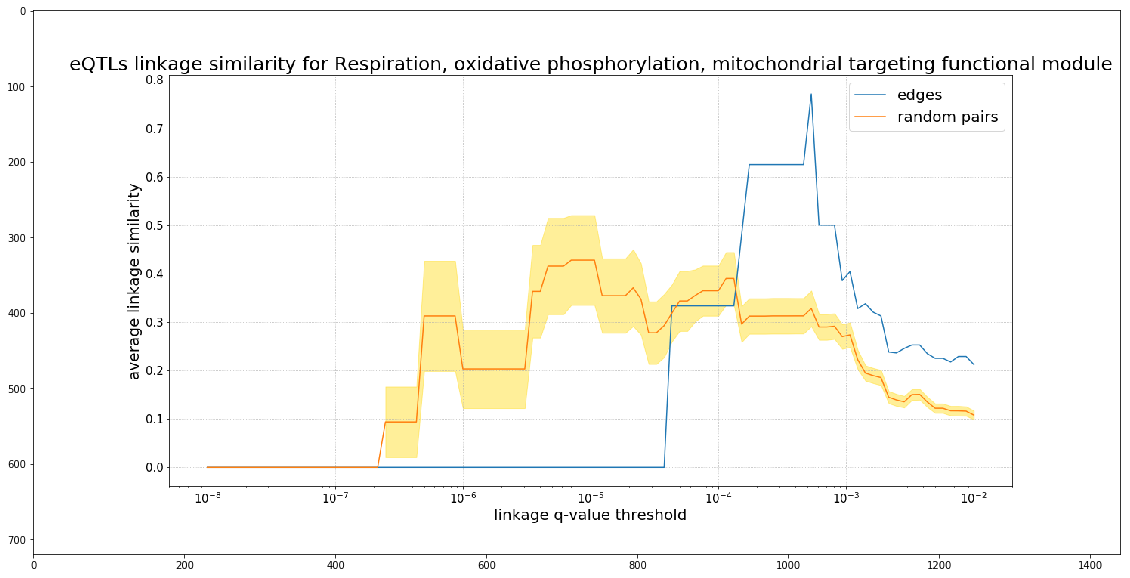

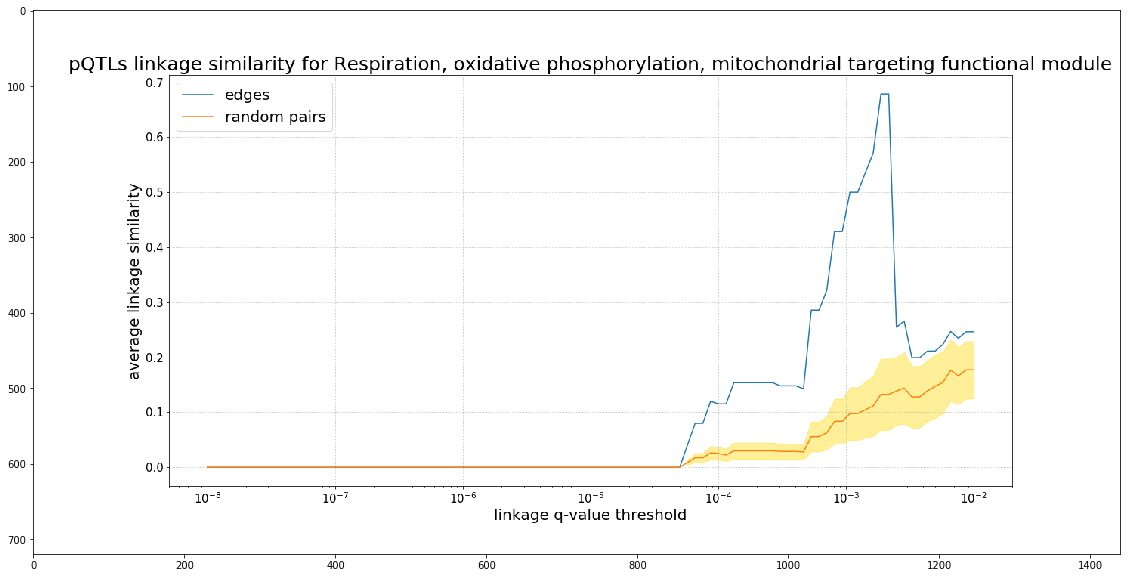

In [43]:
plt.figure(figsize=(20, 10))
plt.imshow(plt.imread("./img/linkage_sharing/thecellmap/all_interactions/eQTLs_Respiration, oxidative phosphorylation, mitochondrial targeting.png"))
plt.show(), plt.close();

plt.figure(figsize=(20, 10))
plt.imshow(plt.imread("./img/linkage_sharing/thecellmap/all_interactions/pQTLs_Respiration, oxidative phosphorylation, mitochondrial targeting.png"))
plt.show(), plt.close();


Once again, **taking into consideration the whole interactome**, we get that for some of the modules genes are not linked to any of computed QTLs:
- Vesicle traffic (pQTLs only)
- Cytokinesis 
- mRNA & tRNA processing (pQTLs only)
- Peroxisome
- Protein degradation/turnover
- Ribosome biogenesis (eQTLs only)
- MVB sorting and pH-depending signalling 
- Transcription & chromatin organization (pQTLs only)
- tRNA wobble modification (pQTLs only)
- DNA replication & repair (eQTLs only)
- mRNA & tRNA processing (pQTLs only)

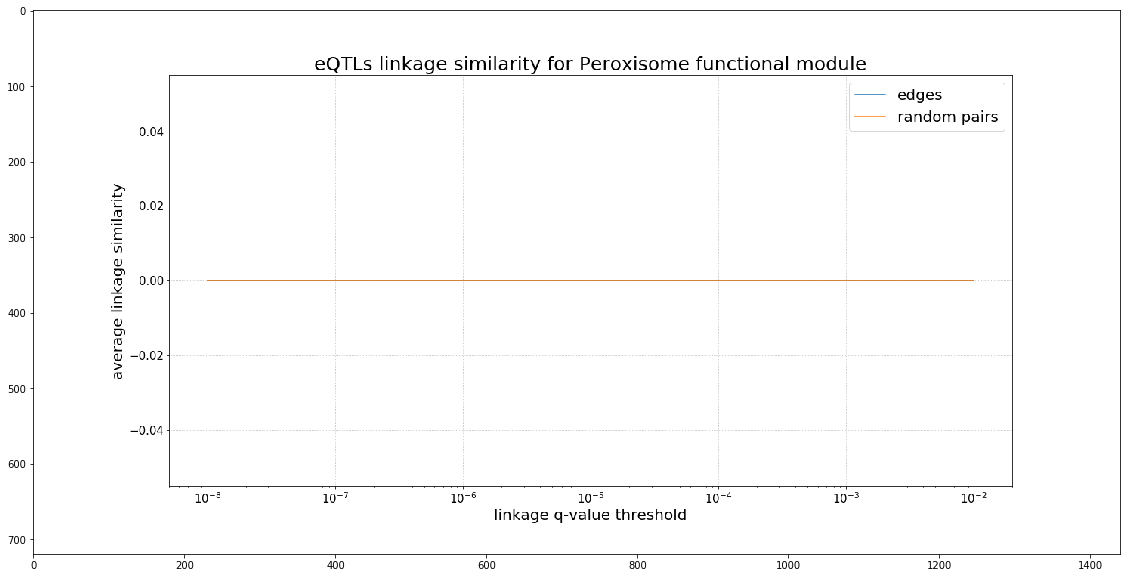

In [53]:
plt.figure(figsize=(20, 10))
plt.imshow(plt.imread("./img/linkage_sharing/thecellmap/all_interactions/eQTLs_Peroxisome.png"))
plt.show(), plt.close();

For some modules an opposite effect is observed, but **further investigation is needed**, because one randomization method is not enough.
List of such clusters:
- DNA replication & repair (pQTLs only, no data for eQTLs)
- rDNA & ncDNA processing (no eQTLs with q-value <= 0.001)
- Ribosome biogenesis (pQTLs only, no data for eQTLs)

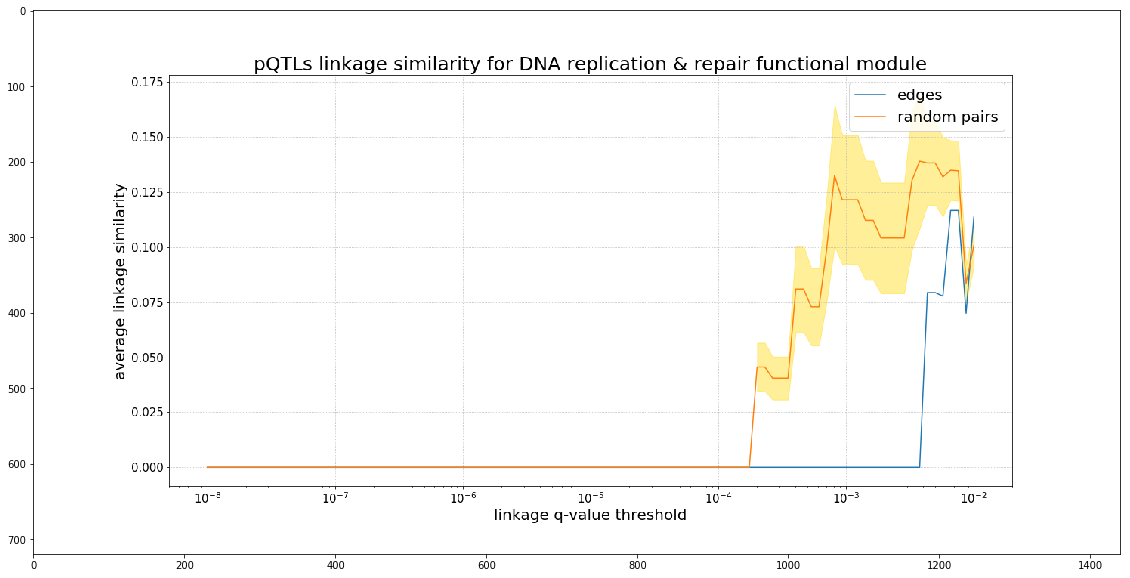

In [39]:
plt.figure(figsize=(20, 10))
plt.imshow(plt.imread("./img/linkage_sharing/thecellmap/all_interactions/pQTLs_DNA replication & repair.png"))
plt.show(), plt.close();


For other modules no evidence of significant linkage sharing was detected.

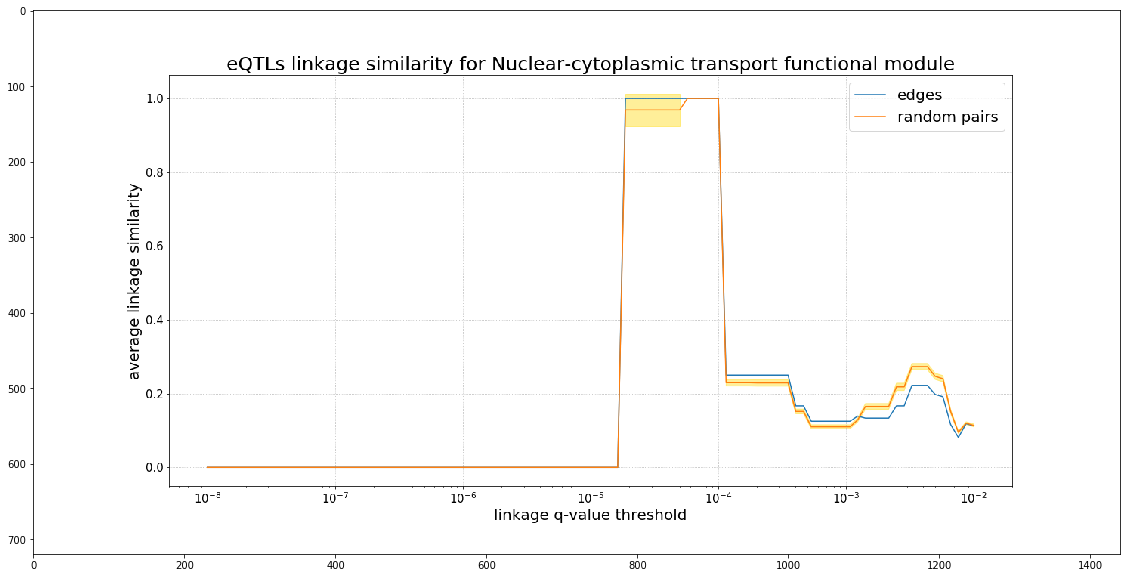

In [65]:

plt.figure(figsize=(20, 10))
plt.imshow(plt.imread("./img/linkage_sharing/thecellmap/all_interactions/eQTLs_Nuclear-cytoplasmic transport.png"))
plt.show(), plt.close();

An attempt to predict pQTLs from eQTLs using functional modules yields even more controversial results, but some of them look promising, as they mostly support previous observations.  
Statistics below corresponds to subgraph of physical interactions, as they are more reliable and meaningful in the biological sense.  
Observable discerpancies show, that **pQTL prediction results should be treated with a certain degree of doubt**, as they can contradict the data obtained by more robust techniques.

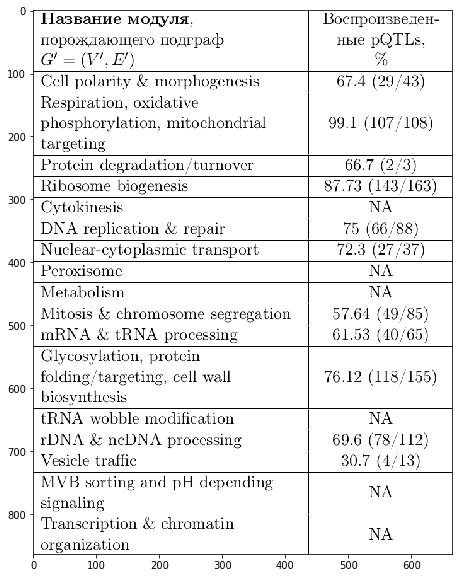

In [41]:
plt.figure(figsize=(20, 10))
plt.imshow(plt.imread("./img/illustrations/pqtl_prediction_from_modules.gif"))
plt.show(), plt.close();

## Interacting genes tend to share linkages: analysis of functional modules from genetic ontology databases

In [6]:
from goatools import obo_parser

# building the GeneOntology DAG
obodag = obo_parser.GODag(
    "./data/geneontology/go-basic.obo",
    optional_attrs=["relationship"]
)

./data/geneontology/go-basic.obo: fmt(1.2) rel(2018-07-02) 47,231 GO Terms; optional_attrs(relationship)


In [7]:
from collections import Counter

# preprocessing of the OBO-DAG:
# computing and storing subtree sizes for each GO term
# speeds up the subsequent functional module extraction process
subtree_size = Counter()
def calc_subtree_size(go_term):
    children = go_term.children
    subtree_size[go_term.id] = 1
    for child in children:
        subtree_size[go_term.id] += calc_subtree_size(child)
    return subtree_size[go_term.id]

for go_term_name in tqdm.tqdm(obodag):
    go_term = obodag[go_term_name]
    if not subtree_size[go_term.id]:
        calc_subtree_size(go_term)
        

  0%|          | 0/47231 [00:00<?, ?it/s]

  4%|▍         | 1914/47231 [00:00<00:02, 16839.05it/s]

  5%|▌         | 2420/47231 [00:00<00:04, 10469.51it/s]

  7%|▋         | 3310/47231 [00:00<00:07, 6065.08it/s] 

  8%|▊         | 3918/47231 [00:00<00:10, 4207.63it/s]

 29%|██▉       | 13675/47231 [00:01<00:02, 13261.68it/s]

 36%|███▌      | 16843/47231 [00:02<00:03, 8353.02it/s] 

100%|██████████| 47231/47231 [00:02<00:00, 22998.81it/s]

In [8]:
# let's set all GO terms with 10 to 15 children in total to be functional module candidates
# the problem is, there are embarrassingly many of those
module_candidates = [go_term for go_term, cnt in subtree_size.items() if 10 <= cnt <= 15]
print("{} candidates in total".format(len(module_candidates)))


1320 candidates in total


In [9]:
from Bio.UniProt.GOA import gafiterator

# how many of them are present in actual yeast genome?
filename = './data/geneontology/goa_yeast.gaf'
occurences = Counter() 
delta = 0
with open(filename) as fp:
    for annot in tqdm.tqdm(gafiterator(fp)):
        if annot["GO_ID"] in module_candidates:
            occurences[annot["GO_ID"]] += 1
        else: 
            delta += 1
     
print(len(occurences))
valid_candidates = occurences.keys()

0it [00:00, ?it/s]

2322it [00:00, 23206.85it/s]

4950it [00:00, 24739.20it/s]

7436it [00:00, 24776.33it/s]

9691it [00:00, 24218.95it/s]

12202it [00:00, 24396.57it/s]

14532it [00:00, 24212.72it/s]

16678it [00:00, 23818.94it/s]

18806it [00:00, 23173.20it/s]

20992it [00:00, 23028.48it/s]

23092it [00:01, 22013.74it/s]

25021it [00:01, 20288.78it/s]

27487it [00:01, 20616.39it/s]

29971it [00:01, 20911.01it/s]

32567it [00:01, 21240.01it/s]

34970it [00:01, 21410.21it/s]

37467it [00:01, 21615.38it/s]

39988it [00:01, 21811.28it/s]

42388it [00:01, 21921.71it/s]

44982it [00:02, 22119.01it/s]

47439it [00:02, 22223.62it/s]

49889it [00:02, 22316.69it/s]

52400it [00:02, 22436.17it/s]

54864it [00:02, 22500.70it/s]

57432it [00:02, 22625.55it/s]

59941it [00:02, 22718.43it/s]

62574it [00:02, 22850.14it/s]

65106it [00:02, 22930.47it/s]

67632it [00:02, 22933.39it/s]

70290it [00:03, 23052.89it/s]

72929it [00:03, 23158.84it/s]

75613it [00:03, 23271.90it/s]

78329it [00:03, 23387.91it/s]

81015it [00:03, 23488.44it/s]

83731it [00:03, 23591.49it/s]

86398it [00:03, 23663.17it/s]

89118it [00:03, 23757.28it/s]

91790it [00:03, 23829.29it/s]

94456it [00:03, 23857.34it/s]

96139it [00:04, 23887.44it/s]

259


In [10]:
# only 259 of them are actually worth investigating
print("{0:3f}% of candidates are not present".format((len(module_candidates) - len(valid_candidates)) / len(module_candidates)))


0.803788% of candidates are not present


  0%|          | 0/259 [00:00<?, ?it/s]

  0%|          | 1/259 [00:00<02:00,  2.15it/s]

  1%|          | 2/259 [00:00<01:50,  2.33it/s]

  1%|          | 3/259 [00:01<01:53,  2.25it/s]

  2%|▏         | 4/259 [00:01<01:50,  2.31it/s]

  2%|▏         | 5/259 [00:02<01:47,  2.36it/s]

  2%|▏         | 6/259 [00:02<01:45,  2.40it/s]

  3%|▎         | 7/259 [00:02<01:43,  2.43it/s]

  3%|▎         | 8/259 [00:03<01:42,  2.46it/s]

  3%|▎         | 9/259 [00:03<01:41,  2.47it/s]

  4%|▍         | 10/259 [00:04<01:40,  2.48it/s]

  4%|▍         | 11/259 [00:04<01:39,  2.50it/s]

  5%|▍         | 12/259 [00:04<01:39,  2.48it/s]

  5%|▌         | 13/259 [00:05<01:39,  2.48it/s]

  5%|▌         | 14/259 [00:05<01:38,  2.48it/s]

  6%|▌         | 15/259 [00:06<01:38,  2.49it/s]

  6%|▌         | 16/259 [00:06<01:37,  2.49it/s]

  7%|▋         | 17/259 [00:06<01:36,  2.50it/s]

  7%|▋         | 18/259 [00:07<01:36,  2.50it/s]

  7%|▋         | 19/259 [00:07<01:35,  2.50it/s]

  8%|▊         | 20/259 [00:07<01:35,  2.50it/s]

  8%|▊         | 21/259 [00:08<01:34,  2.51it/s]

  8%|▊         | 22/259 [00:08<01:34,  2.51it/s]

  9%|▉         | 23/259 [00:09<01:34,  2.50it/s]

  9%|▉         | 24/259 [00:09<01:33,  2.51it/s]

 10%|▉         | 25/259 [00:09<01:33,  2.51it/s]

 10%|█         | 26/259 [00:10<01:32,  2.51it/s]

 10%|█         | 27/259 [00:10<01:32,  2.51it/s]

 11%|█         | 28/259 [00:11<01:31,  2.52it/s]

 11%|█         | 29/259 [00:11<01:31,  2.53it/s]

 12%|█▏        | 30/259 [00:11<01:30,  2.54it/s]

 12%|█▏        | 31/259 [00:12<01:29,  2.54it/s]

 12%|█▏        | 32/259 [00:12<01:29,  2.54it/s]

 13%|█▎        | 33/259 [00:12<01:28,  2.54it/s]

 13%|█▎        | 34/259 [00:13<01:28,  2.55it/s]

 14%|█▎        | 35/259 [00:13<01:27,  2.56it/s]

 14%|█▍        | 36/259 [00:14<01:27,  2.56it/s]

 14%|█▍        | 37/259 [00:14<01:26,  2.57it/s]

 15%|█▍        | 38/259 [00:14<01:25,  2.57it/s]

 15%|█▌        | 39/259 [00:15<01:25,  2.58it/s]

 15%|█▌        | 40/259 [00:15<01:24,  2.58it/s]

 16%|█▌        | 41/259 [00:15<01:24,  2.59it/s]

 16%|█▌        | 42/259 [00:16<01:23,  2.59it/s]

 17%|█▋        | 43/259 [00:16<01:23,  2.60it/s]

 17%|█▋        | 44/259 [00:16<01:22,  2.60it/s]

 17%|█▋        | 45/259 [00:17<01:22,  2.60it/s]

 18%|█▊        | 46/259 [00:17<01:22,  2.60it/s]

 18%|█▊        | 47/259 [00:18<01:21,  2.59it/s]

 19%|█▊        | 48/259 [00:18<01:21,  2.59it/s]

 19%|█▉        | 49/259 [00:18<01:20,  2.60it/s]

 19%|█▉        | 50/259 [00:19<01:20,  2.60it/s]

 20%|█▉        | 51/259 [00:19<01:19,  2.60it/s]

 20%|██        | 52/259 [00:19<01:19,  2.61it/s]

 20%|██        | 53/259 [00:20<01:19,  2.61it/s]

 21%|██        | 54/259 [00:20<01:18,  2.61it/s]

 21%|██        | 55/259 [00:21<01:18,  2.61it/s]

 22%|██▏       | 56/259 [00:21<01:17,  2.61it/s]

 22%|██▏       | 57/259 [00:21<01:17,  2.61it/s]

 22%|██▏       | 58/259 [00:22<01:16,  2.62it/s]

 23%|██▎       | 59/259 [00:22<01:16,  2.62it/s]

 23%|██▎       | 60/259 [00:22<01:15,  2.62it/s]

 24%|██▎       | 61/259 [00:23<01:15,  2.62it/s]

 24%|██▍       | 62/259 [00:23<01:15,  2.62it/s]

 24%|██▍       | 63/259 [00:24<01:14,  2.62it/s]

 25%|██▍       | 64/259 [00:24<01:14,  2.63it/s]

 25%|██▌       | 65/259 [00:24<01:13,  2.63it/s]

 25%|██▌       | 66/259 [00:25<01:13,  2.63it/s]

 26%|██▌       | 67/259 [00:25<01:12,  2.63it/s]

 26%|██▋       | 68/259 [00:25<01:12,  2.64it/s]

 27%|██▋       | 69/259 [00:26<01:12,  2.64it/s]

 27%|██▋       | 70/259 [00:26<01:11,  2.64it/s]

 27%|██▋       | 71/259 [00:26<01:11,  2.64it/s]

 28%|██▊       | 72/259 [00:27<01:10,  2.64it/s]

 28%|██▊       | 73/259 [00:27<01:10,  2.64it/s]

 29%|██▊       | 74/259 [00:27<01:09,  2.64it/s]

 29%|██▉       | 75/259 [00:28<01:09,  2.64it/s]

 29%|██▉       | 76/259 [00:28<01:09,  2.65it/s]

 30%|██▉       | 77/259 [00:29<01:08,  2.65it/s]

 30%|███       | 78/259 [00:29<01:08,  2.65it/s]

 31%|███       | 79/259 [00:29<01:08,  2.65it/s]

 31%|███       | 80/259 [00:30<01:07,  2.65it/s]

 31%|███▏      | 81/259 [00:30<01:07,  2.65it/s]

 32%|███▏      | 82/259 [00:30<01:06,  2.65it/s]

 32%|███▏      | 83/259 [00:31<01:06,  2.65it/s]

 32%|███▏      | 84/259 [00:31<01:06,  2.65it/s]

 33%|███▎      | 85/259 [00:32<01:05,  2.65it/s]

 33%|███▎      | 86/259 [00:32<01:05,  2.65it/s]

 34%|███▎      | 87/259 [00:32<01:04,  2.66it/s]

 34%|███▍      | 88/259 [00:33<01:04,  2.66it/s]

 34%|███▍      | 89/259 [00:33<01:03,  2.66it/s]

 35%|███▍      | 90/259 [00:33<01:03,  2.66it/s]

 35%|███▌      | 91/259 [00:34<01:03,  2.66it/s]

 36%|███▌      | 92/259 [00:34<01:02,  2.66it/s]

 36%|███▌      | 93/259 [00:34<01:02,  2.66it/s]

 36%|███▋      | 94/259 [00:35<01:02,  2.66it/s]

 37%|███▋      | 95/259 [00:35<01:01,  2.66it/s]

 37%|███▋      | 96/259 [00:36<01:01,  2.66it/s]

 37%|███▋      | 97/259 [00:36<01:00,  2.66it/s]

 38%|███▊      | 98/259 [00:36<01:00,  2.66it/s]

 38%|███▊      | 99/259 [00:37<01:00,  2.66it/s]

 39%|███▊      | 100/259 [00:37<00:59,  2.67it/s]

 39%|███▉      | 101/259 [00:37<00:59,  2.67it/s]

 39%|███▉      | 102/259 [00:38<00:58,  2.67it/s]

 40%|███▉      | 103/259 [00:38<00:58,  2.67it/s]

 40%|████      | 104/259 [00:38<00:58,  2.67it/s]

 41%|████      | 105/259 [00:39<00:57,  2.67it/s]

 41%|████      | 106/259 [00:39<00:57,  2.67it/s]

 41%|████▏     | 107/259 [00:40<00:56,  2.67it/s]

 42%|████▏     | 108/259 [00:40<00:56,  2.67it/s]

 42%|████▏     | 109/259 [00:40<00:56,  2.67it/s]

 42%|████▏     | 110/259 [00:41<00:55,  2.67it/s]

 43%|████▎     | 111/259 [00:41<00:55,  2.67it/s]

 43%|████▎     | 112/259 [00:41<00:54,  2.67it/s]

 44%|████▎     | 113/259 [00:42<00:54,  2.67it/s]

 44%|████▍     | 114/259 [00:42<00:54,  2.67it/s]

 44%|████▍     | 115/259 [00:43<00:53,  2.67it/s]

 45%|████▍     | 116/259 [00:43<00:53,  2.67it/s]

 45%|████▌     | 117/259 [00:43<00:53,  2.67it/s]

 46%|████▌     | 118/259 [00:44<00:52,  2.67it/s]

 46%|████▌     | 119/259 [00:44<00:52,  2.68it/s]

 46%|████▋     | 120/259 [00:44<00:51,  2.68it/s]

 47%|████▋     | 121/259 [00:45<00:51,  2.68it/s]

 47%|████▋     | 122/259 [00:45<00:51,  2.68it/s]

 47%|████▋     | 123/259 [00:45<00:50,  2.68it/s]

 48%|████▊     | 124/259 [00:46<00:50,  2.68it/s]

 48%|████▊     | 125/259 [00:46<00:50,  2.68it/s]

 49%|████▊     | 126/259 [00:47<00:49,  2.67it/s]

 49%|████▉     | 127/259 [00:47<00:49,  2.67it/s]

 49%|████▉     | 128/259 [00:47<00:48,  2.67it/s]

 50%|████▉     | 129/259 [00:48<00:48,  2.67it/s]

 50%|█████     | 130/259 [00:48<00:48,  2.67it/s]

 51%|█████     | 131/259 [00:48<00:47,  2.67it/s]

 51%|█████     | 132/259 [00:49<00:47,  2.68it/s]

 51%|█████▏    | 133/259 [00:49<00:47,  2.68it/s]

 52%|█████▏    | 134/259 [00:50<00:46,  2.68it/s]

 52%|█████▏    | 135/259 [00:50<00:46,  2.67it/s]

 53%|█████▎    | 136/259 [00:50<00:45,  2.67it/s]

 53%|█████▎    | 137/259 [00:51<00:45,  2.67it/s]

 53%|█████▎    | 138/259 [00:51<00:45,  2.67it/s]

 54%|█████▎    | 139/259 [00:51<00:44,  2.67it/s]

 54%|█████▍    | 140/259 [00:52<00:44,  2.67it/s]

 54%|█████▍    | 141/259 [00:52<00:44,  2.67it/s]

 55%|█████▍    | 142/259 [00:53<00:43,  2.67it/s]

 55%|█████▌    | 143/259 [00:53<00:43,  2.67it/s]

 56%|█████▌    | 144/259 [00:53<00:42,  2.68it/s]

 56%|█████▌    | 145/259 [00:54<00:42,  2.68it/s]

 56%|█████▋    | 146/259 [00:54<00:42,  2.68it/s]

 57%|█████▋    | 147/259 [00:54<00:41,  2.68it/s]

 57%|█████▋    | 148/259 [00:55<00:41,  2.68it/s]

 58%|█████▊    | 149/259 [00:55<00:41,  2.67it/s]

 58%|█████▊    | 150/259 [00:56<00:40,  2.67it/s]

 58%|█████▊    | 151/259 [00:56<00:40,  2.67it/s]

 59%|█████▊    | 152/259 [00:56<00:40,  2.67it/s]

 59%|█████▉    | 153/259 [00:57<00:39,  2.66it/s]

 59%|█████▉    | 154/259 [00:57<00:39,  2.66it/s]

 60%|█████▉    | 155/259 [00:58<00:39,  2.66it/s]

 60%|██████    | 156/259 [00:58<00:38,  2.66it/s]

 61%|██████    | 157/259 [00:58<00:38,  2.66it/s]

 61%|██████    | 158/259 [00:59<00:37,  2.66it/s]

 61%|██████▏   | 159/259 [00:59<00:37,  2.66it/s]

 62%|██████▏   | 160/259 [01:00<00:37,  2.66it/s]

 62%|██████▏   | 161/259 [01:00<00:36,  2.67it/s]

 63%|██████▎   | 162/259 [01:00<00:36,  2.67it/s]

 63%|██████▎   | 163/259 [01:01<00:35,  2.67it/s]

 63%|██████▎   | 164/259 [01:01<00:35,  2.67it/s]

 64%|██████▎   | 165/259 [01:01<00:35,  2.67it/s]

 64%|██████▍   | 166/259 [01:02<00:34,  2.67it/s]

 64%|██████▍   | 167/259 [01:02<00:34,  2.67it/s]

 65%|██████▍   | 168/259 [01:02<00:34,  2.67it/s]

 65%|██████▌   | 169/259 [01:03<00:33,  2.67it/s]

 66%|██████▌   | 170/259 [01:03<00:33,  2.67it/s]

 66%|██████▌   | 171/259 [01:03<00:32,  2.67it/s]

 66%|██████▋   | 172/259 [01:04<00:32,  2.67it/s]

 67%|██████▋   | 173/259 [01:04<00:32,  2.67it/s]

 67%|██████▋   | 174/259 [01:05<00:31,  2.68it/s]

 68%|██████▊   | 175/259 [01:05<00:31,  2.68it/s]

 68%|██████▊   | 176/259 [01:05<00:31,  2.67it/s]

 68%|██████▊   | 177/259 [01:06<00:30,  2.67it/s]

 69%|██████▊   | 178/259 [01:06<00:30,  2.67it/s]

 69%|██████▉   | 179/259 [01:06<00:29,  2.68it/s]

 69%|██████▉   | 180/259 [01:07<00:29,  2.68it/s]

 70%|██████▉   | 181/259 [01:07<00:29,  2.68it/s]

 70%|███████   | 182/259 [01:08<00:28,  2.68it/s]

 71%|███████   | 183/259 [01:08<00:28,  2.68it/s]

 71%|███████   | 184/259 [01:08<00:28,  2.68it/s]

 71%|███████▏  | 185/259 [01:09<00:27,  2.68it/s]

 72%|███████▏  | 186/259 [01:09<00:27,  2.68it/s]

 72%|███████▏  | 187/259 [01:09<00:26,  2.68it/s]

 73%|███████▎  | 188/259 [01:10<00:26,  2.68it/s]

 73%|███████▎  | 189/259 [01:10<00:26,  2.68it/s]

 73%|███████▎  | 190/259 [01:10<00:25,  2.68it/s]

 74%|███████▎  | 191/259 [01:11<00:25,  2.68it/s]

 74%|███████▍  | 192/259 [01:11<00:25,  2.68it/s]

 75%|███████▍  | 193/259 [01:12<00:24,  2.68it/s]

 75%|███████▍  | 194/259 [01:12<00:24,  2.68it/s]

 75%|███████▌  | 195/259 [01:12<00:23,  2.68it/s]

 76%|███████▌  | 196/259 [01:13<00:23,  2.68it/s]

 76%|███████▌  | 197/259 [01:13<00:23,  2.68it/s]

 76%|███████▋  | 198/259 [01:13<00:22,  2.68it/s]

 77%|███████▋  | 199/259 [01:14<00:22,  2.68it/s]

 77%|███████▋  | 200/259 [01:14<00:22,  2.68it/s]

 78%|███████▊  | 201/259 [01:15<00:21,  2.68it/s]

 78%|███████▊  | 202/259 [01:15<00:21,  2.68it/s]

 78%|███████▊  | 203/259 [01:15<00:20,  2.68it/s]

 79%|███████▉  | 204/259 [01:16<00:20,  2.68it/s]

 79%|███████▉  | 205/259 [01:16<00:20,  2.68it/s]

 80%|███████▉  | 206/259 [01:16<00:19,  2.68it/s]

 80%|███████▉  | 207/259 [01:17<00:19,  2.68it/s]

 80%|████████  | 208/259 [01:17<00:19,  2.68it/s]

 81%|████████  | 209/259 [01:17<00:18,  2.68it/s]

 81%|████████  | 210/259 [01:18<00:18,  2.68it/s]

 81%|████████▏ | 211/259 [01:18<00:17,  2.68it/s]

 82%|████████▏ | 212/259 [01:19<00:17,  2.68it/s]

 82%|████████▏ | 213/259 [01:19<00:17,  2.68it/s]

 83%|████████▎ | 214/259 [01:19<00:16,  2.68it/s]

 83%|████████▎ | 215/259 [01:20<00:16,  2.68it/s]

 83%|████████▎ | 216/259 [01:20<00:16,  2.69it/s]

 84%|████████▍ | 217/259 [01:20<00:15,  2.69it/s]

 84%|████████▍ | 218/259 [01:21<00:15,  2.69it/s]

 85%|████████▍ | 219/259 [01:21<00:14,  2.69it/s]

 85%|████████▍ | 220/259 [01:21<00:14,  2.69it/s]

 85%|████████▌ | 221/259 [01:22<00:14,  2.69it/s]

 86%|████████▌ | 222/259 [01:22<00:13,  2.69it/s]

 86%|████████▌ | 223/259 [01:22<00:13,  2.69it/s]

 86%|████████▋ | 224/259 [01:23<00:13,  2.69it/s]

 87%|████████▋ | 225/259 [01:23<00:12,  2.69it/s]

 87%|████████▋ | 226/259 [01:23<00:12,  2.69it/s]

 88%|████████▊ | 227/259 [01:24<00:11,  2.69it/s]

 88%|████████▊ | 228/259 [01:24<00:11,  2.69it/s]

 88%|████████▊ | 229/259 [01:25<00:11,  2.69it/s]

 89%|████████▉ | 230/259 [01:25<00:10,  2.69it/s]

 89%|████████▉ | 231/259 [01:25<00:10,  2.69it/s]

 90%|████████▉ | 232/259 [01:26<00:10,  2.69it/s]

 90%|████████▉ | 233/259 [01:26<00:09,  2.69it/s]

 90%|█████████ | 234/259 [01:26<00:09,  2.69it/s]

 91%|█████████ | 235/259 [01:27<00:08,  2.69it/s]

 91%|█████████ | 236/259 [01:27<00:08,  2.70it/s]

 92%|█████████▏| 237/259 [01:27<00:08,  2.70it/s]

 92%|█████████▏| 238/259 [01:28<00:07,  2.69it/s]

 92%|█████████▏| 239/259 [01:28<00:07,  2.70it/s]

 93%|█████████▎| 240/259 [01:29<00:07,  2.70it/s]

 93%|█████████▎| 241/259 [01:29<00:06,  2.70it/s]

 93%|█████████▎| 242/259 [01:29<00:06,  2.70it/s]

 94%|█████████▍| 243/259 [01:30<00:05,  2.70it/s]

 94%|█████████▍| 244/259 [01:30<00:05,  2.69it/s]

 95%|█████████▍| 245/259 [01:30<00:05,  2.69it/s]

 95%|█████████▍| 246/259 [01:31<00:04,  2.69it/s]

 95%|█████████▌| 247/259 [01:31<00:04,  2.69it/s]

 96%|█████████▌| 248/259 [01:32<00:04,  2.69it/s]

 96%|█████████▌| 249/259 [01:32<00:03,  2.69it/s]

 97%|█████████▋| 250/259 [01:32<00:03,  2.69it/s]

 97%|█████████▋| 251/259 [01:33<00:02,  2.69it/s]

 97%|█████████▋| 252/259 [01:33<00:02,  2.70it/s]

 98%|█████████▊| 253/259 [01:33<00:02,  2.70it/s]

 98%|█████████▊| 254/259 [01:34<00:01,  2.70it/s]

 98%|█████████▊| 255/259 [01:34<00:01,  2.70it/s]

 99%|█████████▉| 256/259 [01:34<00:01,  2.70it/s]

 99%|█████████▉| 257/259 [01:35<00:00,  2.70it/s]

100%|█████████▉| 258/259 [01:35<00:00,  2.70it/s]

100%|██████████| 259/259 [01:36<00:00,  2.70it/s]

(array([203.,  26.,   8.,   4.,   4.,   5.,   2.,   3.,   2.,   2.]),
 array([  1.,  11.,  21.,  31.,  41.,  51.,  61.,  71.,  81.,  91., 101.]),
 <a list of 10 Patch objects>)

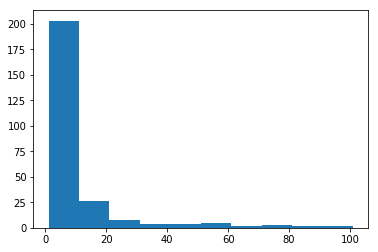

In [11]:
# let's take a look at the distribution of cluster sizes
# histogram shows, that most of them are negligible, consisting of 10 vertices or less
# 157 out of 259 have size of 4 vertices or less
def go_term_to_genes(go_id):
    with open(filename) as fp:
        cluster = [entry["DB_Object_Symbol"] for entry in gafiterator(fp) if entry["GO_ID"] == go_id]
    return np.unique(cluster)

cluster_sizes = []
for go_id in tqdm.tqdm(valid_candidates):
    cluster_sizes += [len(go_term_to_genes(go_id))]
plt.hist(cluster_sizes)

In [12]:
final_candidates = []
for i, go_id in enumerate(valid_candidates):
    if cluster_sizes[i] >= 10:
        print(obodag[go_id].name)    
        final_candidates.append(go_id)   

double-strand break repair
phosphatidylinositol binding
histone deacetylase activity
regulation of cyclin-dependent protein serine/threonine kinase activity
DNA-dependent DNA replication
protein binding, bridging
rRNA binding
phospholipid transport
positive regulation of ATPase activity
glucose transmembrane transporter activity
translational initiation
protein transmembrane transporter activity
protein autophosphorylation
nuclear chromatin
guanyl-nucleotide exchange factor activity
endosome membrane
chromatin binding
proximal promoter sequence-specific DNA binding
mitotic cell cycle
palmitoyltransferase activity
positive regulation of macroautophagy
protein export from nucleus
chromosome segregation
RNA polymerase II transcription factor binding
sister chromatid cohesion
attachment of spindle microtubules to kinetochore
translational elongation
electron transfer activity
cellular response to salt stress
peptidyl-threonine phosphorylation
spindle microtubule
regulation of exit from mit

In [13]:
from collections import defaultdict

# let's finally extract the clusters
cluster_genes_dict = defaultdict()
for go_id in tqdm.tqdm(final_candidates):
    cluster_genes_dict[obodag[go_id].name.replace('/', '|')] = [networks.convert_to_std(gene_name, sys_to_std) for gene_name in go_term_to_genes(go_id)]

  0%|          | 0/58 [00:00<?, ?it/s]

  2%|▏         | 1/58 [00:00<00:24,  2.30it/s]

  3%|▎         | 2/58 [00:00<00:24,  2.27it/s]

  5%|▌         | 3/58 [00:01<00:25,  2.15it/s]

  7%|▋         | 4/58 [00:01<00:25,  2.16it/s]

  9%|▊         | 5/58 [00:02<00:23,  2.23it/s]

 10%|█         | 6/58 [00:02<00:22,  2.29it/s]

 12%|█▏        | 7/58 [00:03<00:21,  2.32it/s]

 14%|█▍        | 8/58 [00:03<00:21,  2.36it/s]

 16%|█▌        | 9/58 [00:03<00:20,  2.38it/s]

 17%|█▋        | 10/58 [00:04<00:19,  2.40it/s]

 19%|█▉        | 11/58 [00:04<00:19,  2.42it/s]

 21%|██        | 12/58 [00:04<00:18,  2.44it/s]

 22%|██▏       | 13/58 [00:05<00:18,  2.45it/s]

 24%|██▍       | 14/58 [00:05<00:17,  2.47it/s]

 26%|██▌       | 15/58 [00:06<00:17,  2.46it/s]

 28%|██▊       | 16/58 [00:06<00:17,  2.45it/s]

 29%|██▉       | 17/58 [00:06<00:16,  2.45it/s]

 31%|███       | 18/58 [00:07<00:16,  2.45it/s]

 33%|███▎      | 19/58 [00:07<00:15,  2.45it/s]

 34%|███▍      | 20/58 [00:08<00:15,  2.46it/s]

 36%|███▌      | 21/58 [00:08<00:15,  2.46it/s]

 38%|███▊      | 22/58 [00:08<00:14,  2.46it/s]

 40%|███▉      | 23/58 [00:09<00:14,  2.45it/s]

 41%|████▏     | 24/58 [00:09<00:13,  2.45it/s]

 43%|████▎     | 25/58 [00:10<00:13,  2.45it/s]

 45%|████▍     | 26/58 [00:10<00:13,  2.45it/s]

 47%|████▋     | 27/58 [00:10<00:12,  2.46it/s]

 48%|████▊     | 28/58 [00:11<00:12,  2.46it/s]

 50%|█████     | 29/58 [00:11<00:11,  2.47it/s]

 52%|█████▏    | 30/58 [00:12<00:11,  2.47it/s]

 53%|█████▎    | 31/58 [00:12<00:10,  2.47it/s]

 55%|█████▌    | 32/58 [00:12<00:10,  2.48it/s]

 57%|█████▋    | 33/58 [00:13<00:10,  2.48it/s]

 59%|█████▊    | 34/58 [00:13<00:09,  2.48it/s]

 60%|██████    | 35/58 [00:14<00:09,  2.49it/s]

 62%|██████▏   | 36/58 [00:14<00:08,  2.49it/s]

 64%|██████▍   | 37/58 [00:14<00:08,  2.49it/s]

 66%|██████▌   | 38/58 [00:15<00:08,  2.49it/s]

 67%|██████▋   | 39/58 [00:15<00:07,  2.49it/s]

 69%|██████▉   | 40/58 [00:16<00:07,  2.50it/s]

 71%|███████   | 41/58 [00:16<00:06,  2.50it/s]

 72%|███████▏  | 42/58 [00:16<00:06,  2.50it/s]

 74%|███████▍  | 43/58 [00:17<00:06,  2.50it/s]

 76%|███████▌  | 44/58 [00:17<00:05,  2.50it/s]

 78%|███████▊  | 45/58 [00:17<00:05,  2.50it/s]

 79%|███████▉  | 46/58 [00:18<00:04,  2.50it/s]

 81%|████████  | 47/58 [00:18<00:04,  2.51it/s]

 83%|████████▎ | 48/58 [00:19<00:03,  2.51it/s]

 84%|████████▍ | 49/58 [00:19<00:03,  2.51it/s]

 86%|████████▌ | 50/58 [00:19<00:03,  2.51it/s]

 88%|████████▊ | 51/58 [00:20<00:02,  2.51it/s]

 90%|████████▉ | 52/58 [00:20<00:02,  2.51it/s]

 91%|█████████▏| 53/58 [00:21<00:01,  2.52it/s]

 93%|█████████▎| 54/58 [00:21<00:01,  2.52it/s]

 95%|█████████▍| 55/58 [00:21<00:01,  2.52it/s]

 97%|█████████▋| 56/58 [00:22<00:00,  2.52it/s]

 98%|█████████▊| 57/58 [00:22<00:00,  2.52it/s]

100%|██████████| 58/58 [00:22<00:00,  2.52it/s]

In [14]:
def extract_cluster_subgraphs(functional_modules_dict, interactome_graph, simplify=False):
    module_graphs_dict = {}
    for mname in functional_modules_dict.keys():
        mgraph = interactome_graph.subgraph(
            set(functional_modules_dict[mname])
            & set(interactome_graph.vs["name"])
        )
        if simplify:
            mgraph = mgraph.simplify()
            mgraph.vs.select(_degree=0).delete()
        ig.plot(
            mgraph,
            target="./img/functional_module_graphs/"
                   + "geneontology/"
                   + ("simplified/" if simplify else "raw/") 
                   + mname + ".png",
            vertex_label=mgraph.vs["name"]
        );
        module_graphs_dict[mname] = mgraph
    return module_graphs_dict

pd.DataFrame(
    [(mname, mgraph.vcount(), mgraph.ecount()) for mname, mgraph in 
     extract_cluster_subgraphs(cluster_genes_dict, interaction_graphs_dict["all"]).items()], 
    columns=["Module name", "Num. vertices", "Num. edges"]
)

,Module name,Num. vertices,Num. edges
0,RNA polymerase II transcription factor binding,12,30
1,translational initiation,33,728
2,peptidyl-threonine phosphorylation,20,267
3,phospholipid transport,17,150
4,regulation of cyclin-dependent protein serine|...,23,185
5,sister chromatid cohesion,11,76
6,metallopeptidase activity,15,38
7,phosphatidylinositol binding,15,234
8,protein folding,77,941
9,mitotic cell cycle,19,81


In [15]:
pd.DataFrame(
    [(mname, mgraph.vcount(), mgraph.ecount()) for mname, mgraph in 
     extract_cluster_subgraphs(cluster_genes_dict, interaction_graphs_dict["all"], simplify=True).items()], 
    columns=["Module name", "Num. vertices", "Num. edges"]
)

,Module name,Num. vertices,Num. edges
0,RNA polymerase II transcription factor binding,6,6
1,translational initiation,31,128
2,peptidyl-threonine phosphorylation,19,44
3,phospholipid transport,17,37
4,regulation of cyclin-dependent protein serine|...,20,53
5,sister chromatid cohesion,10,13
6,metallopeptidase activity,9,9
7,phosphatidylinositol binding,12,21
8,protein folding,73,351
9,mitotic cell cycle,17,24


In [17]:
%%capture --no-stderr

Q_RANGE = np.logspace(-8, -2, 100)

for interaction_type in ["all", "genetic", "physical"]:
    interactome_graph = interaction_graphs_dict[interaction_type]
    for qtl_type, qtl_df in [("eQTLs", eQTLs_df), ("pQTLs", pQTLs_df)]:
        for module_name in cluster_genes_dict.keys():
            module_graph = interactome_graph.subgraph(
                set(cluster_genes_dict[module_name])
                & set(interactome_graph.vs["name"])
            ).simplify()
            module_graph.vs.select(_degree=0).delete()
            if module_graph.vcount() <= 2:
                print("{} — no data!".format(module_name))
                continue
            
            module_graph_analyzer = qtls.LinkageSharingAnalyzer(
                qtl_type=qtl_type,
                qtl_df=qtl_df,
                module_name=module_name,
                module_graph=module_graph,
                q_value_thresholds=Q_RANGE
            )
    
            module_graph_analyzer.analyze_robustness_of_linkage_sharing(
                title=qtl_type + " linkage similarity for " + module_name + " GO Term",
                destination_folder="./img/linkage_sharing/geneontology/" + interaction_type + "_interactions/"
            )
            
gc.collect()
%reset_selective interactome_graph

/home/vvi/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1910: RuntimeWarning: invalid value encountered in multiply
  lower_bound = self.a * scale + loc
/home/vvi/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1911: RuntimeWarning: invalid value encountered in multiply
  upper_bound = self.b * scale + loc


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


/home/vvi/Science/eQTL_analysis/lib/qtls.py:227: RuntimeWarning: Cannot shuffle graph, maybe there is only a single one? at gengraph_graph_molloy_hash.cpp:332
  method="vl"


InternalError: Error at gengraph_mr-connected.cpp:168: Cannot make a connected graph from the given degree sequence, Invalid value

In [22]:
for i, name in enumerate(cluster_genes_dict.keys()):
    print(i, name)

0 RNA polymerase II transcription factor binding
1 translational initiation
2 protein dephosphorylation
3 peptidyl-threonine phosphorylation
4 phospholipid transport
5 regulation of cyclin-dependent protein serine|threonine kinase activity
6 sister chromatid cohesion
7 metallopeptidase activity
8 phosphatidylinositol binding
9 protein folding
10 mitotic cell cycle
11 nuclear chromatin
12 peptidyl-serine phosphorylation
13 site of polarized growth
14 histone deacetylase activity
15 protein autophosphorylation
16 protein-lysine N-methyltransferase activity
17 cytoplasmic microtubule
18 double-strand break repair
19 Ras protein signal transduction
20 peroxisome
21 protein kinase binding
22 attachment of spindle microtubules to kinetochore
23 small GTPase mediated signal transduction
24 protein polyubiquitination
25 macroautophagy
26 cell cycle
27 protein export from nucleus
28 mRNA binding
29 translational elongation
30 RNA polymerase II proximal promoter sequence-specific DNA binding
31 

In [25]:
module_name = 'protein-lysine N-methyltransferase activity'
interactome_graph = interaction_graphs_dict["all"]
module_graph = interactome_graph.subgraph(
                set(cluster_genes_dict[module_name])
                & set(interactome_graph.vs["name"])
            ).simplify()
module_graph.vs.select(_degree=0).delete()
            
%reset_selective module_name|module_graph|interactome_graph

## Generalization: testing hypothesis on human data

## ModuleQTLs: concept introduction and rationale